In [21]:
#!pip install tensorflow-gpu==2.0.0-alpha0
#!pip install tensorflow==2.0.0-alpha0
!pip install "tensorflow-text==v2.15.0"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.

In [1]:
!pip install arabic_reshaper
!pip install python-bidi

In [2]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

#tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from bidi.algorithm import get_display
import arabic_reshaper
import unicodedata
import re
import numpy as np
import os
import time
import math

print(tf.__version__)

2.15.1


## Download and prepare the dataset

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [3]:
# Path for the dataset file
path_to_file = "/content/ara_.txt"

In [4]:
def unicode_to_ascii(s):
    '''
    Args:
        s : UniCode file
    Returns:
        ASCII file

    Converts the unicode file to ascii
    '''
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    '''
    Args:
        w : A single word
    Returns:
        w : Single normalize word

    Convert Unicode to ASCII
    Creating a space between a word and the punctuation following it
    eg: "he is a boy." => "he is a boy ."
    Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation

    Replacing everything with space except (a-z, A-Z, ا-ي ".", "?", "!", ",")

    Adding a start and an end token to the sentence

    '''
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = re.sub(r"[^a-zA-Z؀-ۿ?.!,¿]+", " ", w)
    w = w.rstrip().strip()

    w = '<start> %s <end>'%w
    return w

In [5]:
def create_dataset(path, num_examples):
    '''
    Args:
        path: Path of the dataset file
        num_examples: Threshold to read a range from dataset
    Returns:
        word_pairs : All readed words from dataset as a pairs

    1. Remove the accents
    2. Clean the sentences
    3. Return word pairs in the format: [ENGLISH, ARABIC]
    '''
    lines = open(path, encoding='utf-8-sig').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    print(len(lines))
    print(len(lines[:num_examples]))
    return word_pairs

In [6]:
class LanguageIndex():
    ''' Creates a word -> index mapping

    This class creates a word -> index mapping
    (e.g., "dad" -> 5) and vice-versa
    (e.g., 5 -> "dad") for each language,

    Attributes:
        lang: A langauage to map to its index.
    '''
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0

        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

• Define function to get the maximum length of tensor for index mapping, then define a load data set function that’s return input tensor, target tensor, input language, target language, max length input and maximum length target.


In [7]:
def max_length(tensor):
    '''
    Args:
        tensor: Tensor of indexed words
    Return:
        The maximum size for the longest tensor
    '''
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    '''
    Args:
        path: Path of the dataset
        num_examples: Threshold to read a range from dataset
    Return:
        input_tensor: Tensor of the input language
        target_tensor: Tensor for the traget to translate language
        inp_lang: Indexed input language
        targ_lang:  Indexed traget to translate language
        max_length_inp: Maximum length of the input language
        max_length_tar: Maximum length of the traget language

    Creating cleaned input, output pairs,
    Index language using the class defined above,
    Vectorize the input and target languages,
    Calculate max_length of input and output tensor, then
    Padding the input and output tensor to the maximum length

    '''
    pairs = create_dataset(path, num_examples)

    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)


    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]

    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,
                                                                 maxlen=max_length_inp,
                                                                 padding='post')

    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,
                                                                  maxlen=max_length_tar,
                                                                  padding='post')

    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [8]:
# Try experimenting with the size of that dataset
num_examples = 30000
# Load the dataset and return Tensor of the input, Tensor for the traget, Indexed input, Indexed traget, Max length input, Max length target
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

10742
10742


In [9]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(8593, 8593, 2149, 2149)

### Create a tf.data dataset
• Define hyper-parameters and load dataset to tensors.![alt text](https://)

In [10]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 24
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 300
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

Here, we'll implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. The following diagram shows that each input word is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

We're using *Bahdanau attention*. Lets decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, 1)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU
  
The shapes of all the vectors at each step have been specified in the comments in the code:

•	Define GRU where if GPU is used we use a x3 faster GRU
 ![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

In [11]:
def gru(units):

    '''
    Args:
        units: number of units
    Return:
        GRU units

    If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
    the code automatically does that.
    '''
    return tf.keras.layers.GRU(units,
                                return_sequences=True,
                                return_state=True,
                                recurrent_activation='sigmoid',
                                recurrent_initializer='glorot_uniform')

•	Define Encoder Class

In [12]:
class Encoder(tf.keras.Model):
    ''' Create the word embeddings, then fed as input into the main network,

    This class create encoder which consists of two multi-layer RNNs – an encoder
    for the source language and a decoder for the target language.

    Attributes:
        vocab_size: Size of vocabulary
        embedding_dim: Embedding vector length
        enc_units:  Number of GRUs units
        batch_sz: batch size ** minimize it for low RAM
    '''
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [13]:
class Decoder(tf.keras.Model):
    ''' Create the decoder, also needs to have access to the source information.

    This class create decoder which consists of decoder_cell (similar to encoder_cell),
    a helper, and the previous encoder_state as inputs.

    Attributes:
        vocab_size: Size of vocabulary
        embedding_dim: Embedding vector length
        enc_units:  Number of GRUs units
        batch_sz: batch size ** minimize it for low RAM
    '''
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)

        return x, state, attention_weights

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

    def saved_hidden_state(self):
        return self.gru.states

In [14]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

## Define the optimizer and the loss function

In [15]:
optimizer = tf.keras.optimizers.Adam()


def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

## Save model (Object-based saving)

In [16]:
save_dir = './model_save'
encoder_prefix = os.path.join(save_dir, "encoder_weights.h5")
decoder_prefix = os.path.join(save_dir, "decoder_weights.h5")

## Load saved model

In [17]:
encoder.load_weights(encoder_prefix)
decoder.load_weights(decoder_prefix)

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [18]:
EPOCHS = 15
best_total_loss = 0.0071

for epoch in range(EPOCHS):
    start = time.time()

    hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0

        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)

            dec_hidden = enc_hidden

            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

                loss += loss_function(targ[:, t], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))

        total_loss += batch_loss

        variables = encoder.variables + decoder.variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))

    if best_total_loss > (total_loss / N_BATCH):

        best_total_loss = total_loss

        encoder.save_weights(encoder_prefix)
        decoder.save_weights(decoder_prefix)

        print('Saving weights at epoch {} with Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))

    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.5627
Epoch 1 Batch 100 Loss 0.9521
Epoch 1 Batch 200 Loss 0.9877
Epoch 1 Batch 300 Loss 0.7247
Epoch 1 Loss 0.9475
Time taken for 1 epoch 386.8103313446045 sec

Epoch 2 Batch 0 Loss 0.9613
Epoch 2 Batch 100 Loss 0.8517
Epoch 2 Batch 200 Loss 0.6880
Epoch 2 Batch 300 Loss 0.7867
Epoch 2 Loss 0.7982
Time taken for 1 epoch 381.3505561351776 sec

Epoch 3 Batch 0 Loss 0.7778
Epoch 3 Batch 100 Loss 0.7569
Epoch 3 Batch 200 Loss 0.6538
Epoch 3 Batch 300 Loss 0.6295
Epoch 3 Loss 0.7099
Time taken for 1 epoch 375.62341022491455 sec

Epoch 4 Batch 0 Loss 0.6321
Epoch 4 Batch 100 Loss 0.5444
Epoch 4 Batch 200 Loss 0.7066
Epoch 4 Batch 300 Loss 0.6819
Epoch 4 Loss 0.6438
Time taken for 1 epoch 377.5061173439026 sec

Epoch 5 Batch 0 Loss 0.5668
Epoch 5 Batch 100 Loss 0.5884
Epoch 5 Batch 200 Loss 0.5583
Epoch 5 Batch 300 Loss 0.6221
Epoch 5 Loss 0.5879
Time taken for 1 epoch 374.45505118370056 sec

Epoch 6 Batch 0 Loss 0.5471
Epoch 6 Batch 100 Loss 0.5919
Epoch 6 Batch 200 Lo

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [19]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [20]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)

    heatmap = ax.matshow(attention, cmap='rainbow')

    for y in range(attention.shape[0]):
        for x in range(attention.shape[1]):
            ax.text(x , y, '%.4f' % attention[y, x],
                     horizontalalignment='center',
                     verticalalignment='center', color='black')

    fig.colorbar(heatmap)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [35]:
def translate(sentence, encoder=encoder, decoder=decoder, inp_lang=inp_lang,targ_lang =targ_lang, max_length_inp=max_length_inp, max_length_targ=max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, get_display(arabic_reshaper.reshape(sentence)).split(' '), result.split(' '))

## Evaluation and see output

Input: <start> هل يعجبك ذلك <end>
Predicted translation: do you like to me ? <end> 


<ipython-input-20-7abeee6273e8>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict)
<ipython-input-20-7abeee6273e8>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


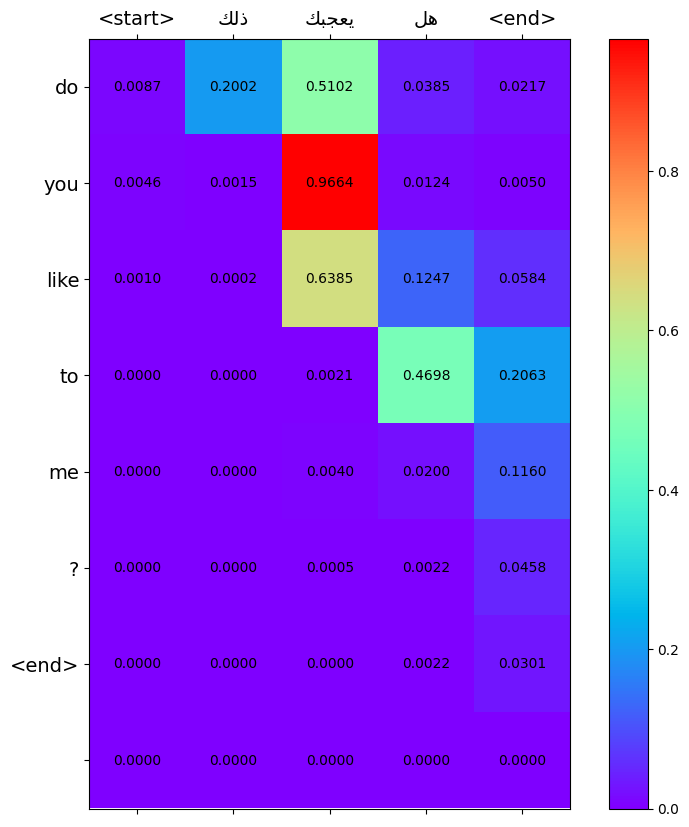

In [38]:
translate(u'هل يعجبك ذلك', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> كيف تفعل ذلك <end>
Predicted translation: how do you do that ? <end> 


<ipython-input-20-7abeee6273e8>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict)
<ipython-input-20-7abeee6273e8>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


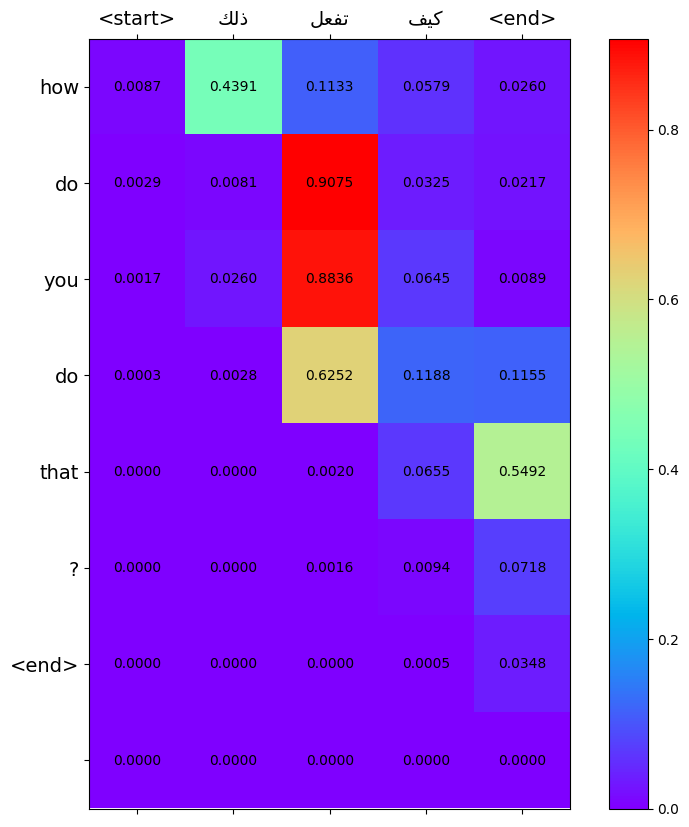

In [32]:
translate(u'كيف تفعل ذلك ', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> اريد افضل من ذلك <end>
Predicted translation: i want to talk about it . <end> 


<ipython-input-20-7abeee6273e8>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict)
<ipython-input-20-7abeee6273e8>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


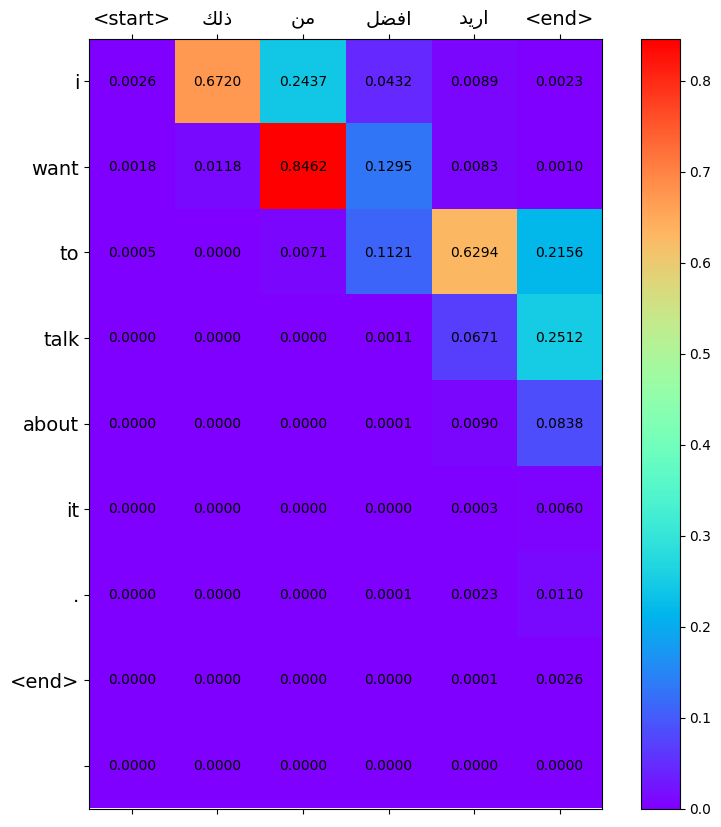

In [26]:
translate(u'اريد افضل من ذلك', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> هل يعمل ذلك بشكل جيد <end>
Predicted translation: do you think good ? <end> 


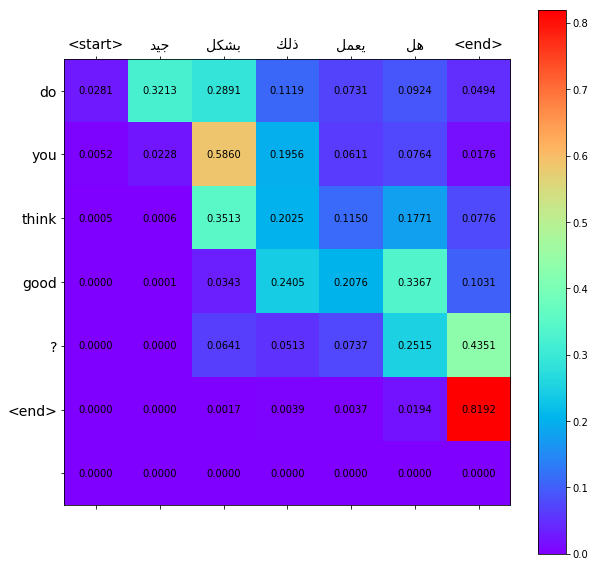

In [ ]:
translate(u'هل يعمل ذلك بشكل جيد', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> احب عملي <end>
Predicted translation: i love my job . <end> 


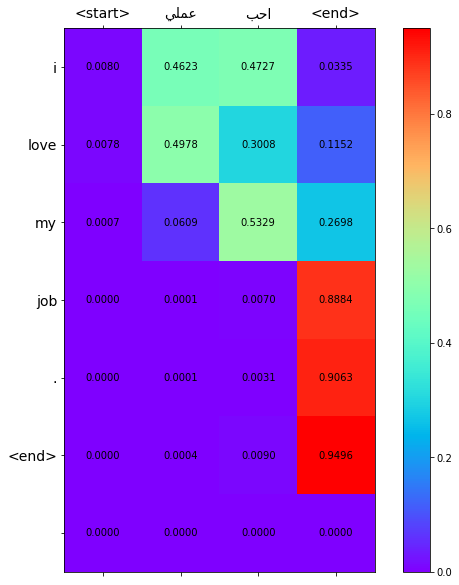

In [ ]:
translate(u'احب عملي', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> لا تستسلم انا متاكد <end>
Predicted translation: don t know you . <end> 


<ipython-input-20-7abeee6273e8>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict)
<ipython-input-20-7abeee6273e8>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


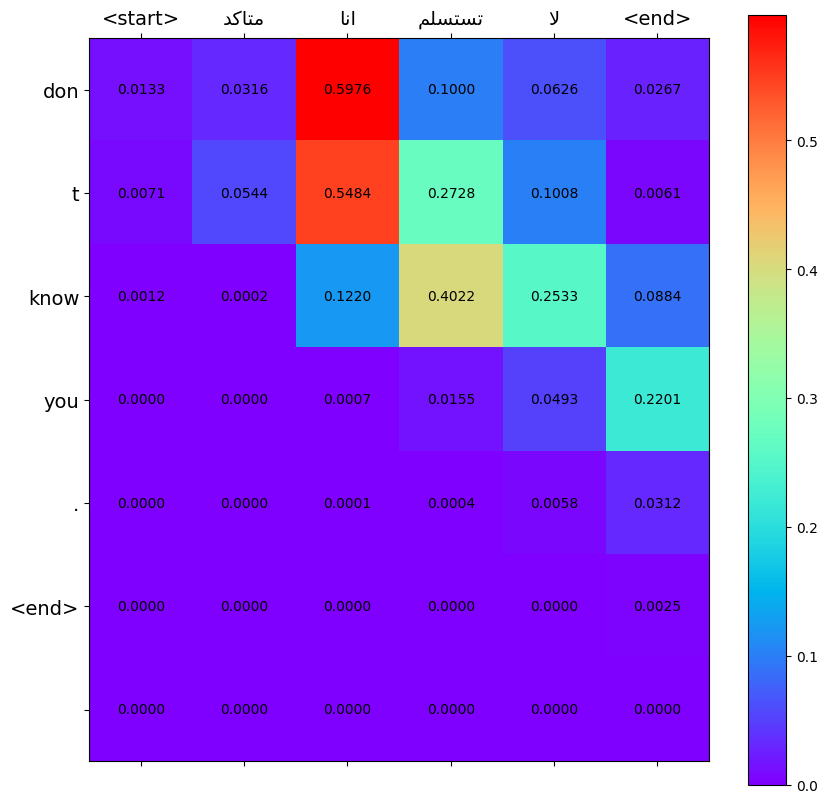

In [31]:
translate(u'لا تستسلم انا متاكد', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> ماذا اقول بعد ما قيل <end>
Predicted translation: what do you think for do ? <end> 


<ipython-input-20-7abeee6273e8>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict)
<ipython-input-20-7abeee6273e8>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


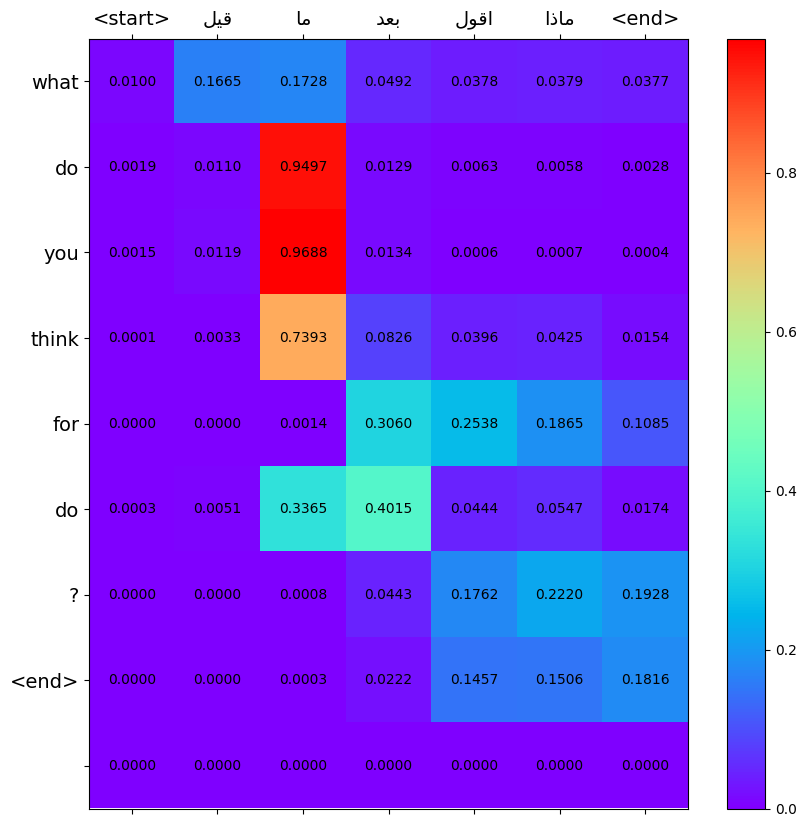

In [30]:
translate(u'ماذا اقول بعد ما قيل', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> انا لا اعرف متى سيكون لدي الوقت <end>
Predicted translation: i don t know the time . <end> 


<ipython-input-20-7abeee6273e8>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict)
<ipython-input-20-7abeee6273e8>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


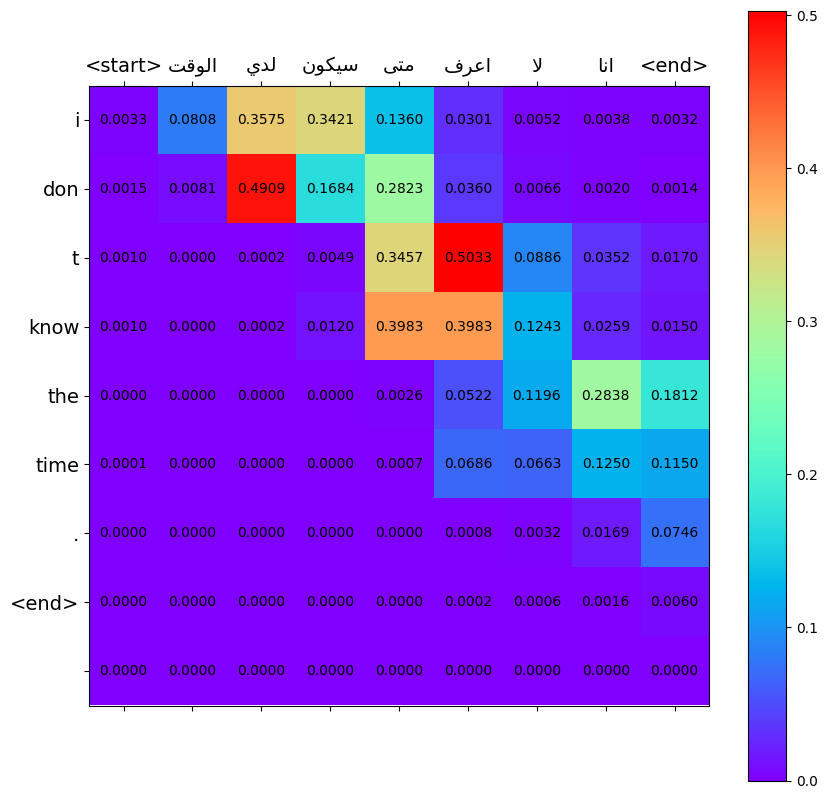

In [27]:
translate(u'انا لا اعرف متى سيكون لدي الوقت', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> اهلا وسهلا <end>
Predicted translation: welcome . <end> 


<ipython-input-20-7abeee6273e8>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict)
<ipython-input-20-7abeee6273e8>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


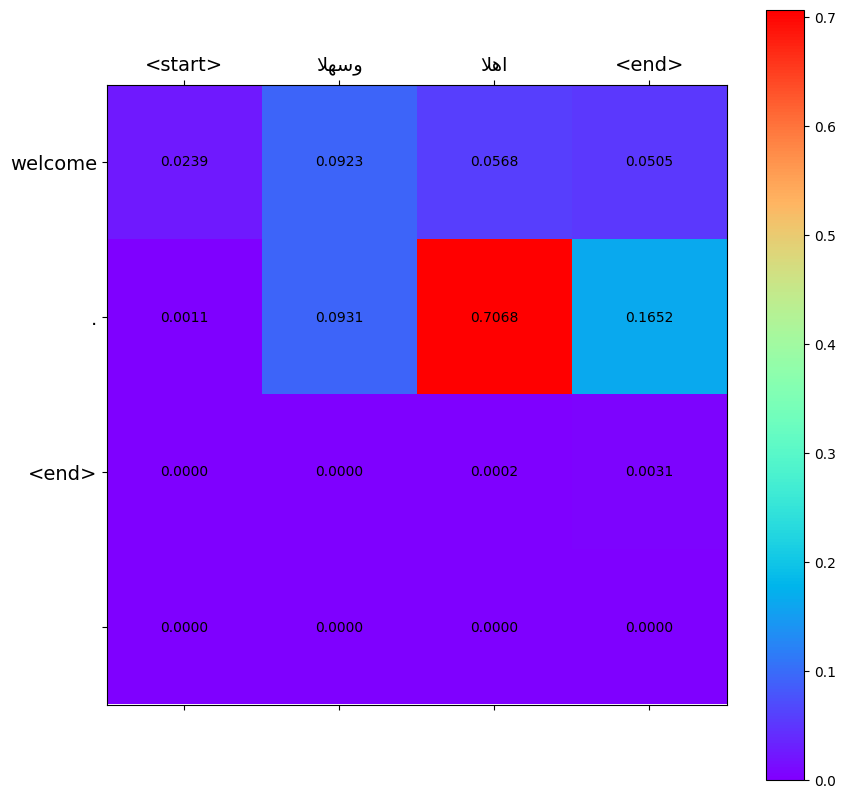

In [28]:
translate(u'اهلا وسهلا', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)